In [17]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib
#%matplotlib notebook
#%matplotlib qt5
%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # bigger figure!


sns.set() # better looking figs


In [18]:
# our own set of small helper functions for plotting, etc
from utils import plot_embedding, plot_compare_embeddings, show_heatmap, plot_confusion_matrix

In [19]:
df = pd.read_csv("full-data.csv")
df["clipId"] = df["clipName"].apply(lambda x: x[-8:-6])

# re-order columns + keep only useful ones
df = df[['pptID',
 'fileName',
 'condition',
 'age',
 'gender',
 'nationality',
 'firstLang',
 'trial',
 'clipId',
 'freetext',
 'q01',
 'q02',
 'q03',
 'q04',
 'q05',
 'q06',
 'q07',
 'q08',
 'q09',
 'q10',
 'q11',
 'q12',
 'q13',
 'q14',
 'q15',
 'q16',
 'q17',
 'q18',
 'q19',
 'q20',
 'q21',
 'q22',
 'q23',
 'q24',
 'q25',
 'q26',
 'q27',
 'q28',
 'q29',
 'q30']]

df

,pptID,fileName,condition,age,gender,nationality,firstLang,trial,clipId,freetext,...,q21,q22,q23,q24,q25,q26,q27,q28,q29,q30
0,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,1,04,PLAY TOGETHER THE CARD GAME TO ENJOY THEM . IN...,...,2,2,1,2,1,2,2,2,2,2
1,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,2,09,PLAYING TOGETHER FOR TWO CHILDREN . TO PLAY CA...,...,3,4,3,3,3,4,3,4,3,3
2,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,3,16,PLAYING TOGETHER THE GAME. PLAY TO LEARNING TH...,...,3,4,3,3,3,3,3,4,3,3
3,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,4,02,PLAYING TO LEARNING TOGETHER. TO PLAY INTEREST...,...,3,4,3,3,2,2,3,3,3,3
4,10,10kinos8b34va6_data.csv,1,23,Male,American,English,1,15,I notice that they slow down towards the end m...,...,1,1,2,1,1,2,2,2,2,2
5,10,10kinos8b34va6_data.csv,1,23,Male,American,English,2,02,The child on the right seems to be taking over...,...,1,0,1,1,1,3,4,1,3,0
6,10,10kinos8b34va6_data.csv,1,23,Male,American,English,3,08,"Both seem pretty calm, but the child on the le...",...,4,1,4,1,2,1,1,2,3,2
7,10,10kinos8b34va6_data.csv,1,23,Male,American,English,4,11,These children seem to be working together pre...,...,1,1,1,1,1,1,2,2,1,1
8,155,10kinqv5zq7rl5_data.csv,2,28,Male,American,English,1,12,They got along quite well and helped each othe...,...,0,4,3,2,2,4,2,2,4,2
9,155,10kinqv5zq7rl5_data.csv,2,28,Male,American,English,2,07,They played separately largely. They were fine...,...,3,0,4,1,3,4,3,3,0,2


Rename `qXX` columns with the names of the actual constructs

In [20]:
constructs=["Sad", "Happy", "Angry", "Excited", "Calm", "Friendly", "Aggressive", "Engaged", "Distracted", "Bored", "Frustrated","Dominant","Submissive"]

index = df.columns.tolist()
index = index[0:10] + ["Competing", "Cooperating", "PlaySeparate", "PlayTogether"] + [c for c1 in constructs for c in ['left' + c1, 'right' + c1]]
df.columns=index
df

,pptID,fileName,condition,age,gender,nationality,firstLang,trial,clipId,freetext,...,leftDistracted,rightDistracted,leftBored,rightBored,leftFrustrated,rightFrustrated,leftDominant,rightDominant,leftSubmissive,rightSubmissive
0,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,1,04,PLAY TOGETHER THE CARD GAME TO ENJOY THEM . IN...,...,2,2,1,2,1,2,2,2,2,2
1,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,2,09,PLAYING TOGETHER FOR TWO CHILDREN . TO PLAY CA...,...,3,4,3,3,3,4,3,4,3,3
2,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,3,16,PLAYING TOGETHER THE GAME. PLAY TO LEARNING TH...,...,3,4,3,3,3,3,3,4,3,3
3,186,10kin7dm75u231_data.csv,2,30,Female,Indian,Tamil,4,02,PLAYING TO LEARNING TOGETHER. TO PLAY INTEREST...,...,3,4,3,3,2,2,3,3,3,3
4,10,10kinos8b34va6_data.csv,1,23,Male,American,English,1,15,I notice that they slow down towards the end m...,...,1,1,2,1,1,2,2,2,2,2
5,10,10kinos8b34va6_data.csv,1,23,Male,American,English,2,02,The child on the right seems to be taking over...,...,1,0,1,1,1,3,4,1,3,0
6,10,10kinos8b34va6_data.csv,1,23,Male,American,English,3,08,"Both seem pretty calm, but the child on the le...",...,4,1,4,1,2,1,1,2,3,2
7,10,10kinos8b34va6_data.csv,1,23,Male,American,English,4,11,These children seem to be working together pre...,...,1,1,1,1,1,1,2,2,1,1
8,155,10kinqv5zq7rl5_data.csv,2,28,Male,American,English,1,12,They got along quite well and helped each othe...,...,0,4,3,2,2,4,2,2,4,2
9,155,10kinqv5zq7rl5_data.csv,2,28,Male,American,English,2,07,They played separately largely. They were fine...,...,3,0,4,1,3,4,3,3,0,2


Compute, for each left/right constructs, the differences and sums. This gives us an insight on the inbalance of the given construct between the children, and the overall 'magnitude' of the construct in the clip.

In [21]:
for c in constructs:
    df["diff"+c] = abs(df["left" + c] - df["right" + c])
    df["sum"+c] = df["left" + c] + df["right" + c] - 4
    
# create 2 lists of columns names, one for left/right constructs, one for diff/sum constructs
columnsLeftRight=[]
columnsDiffSum=[]

for c in constructs:
    columnsLeftRight.append("left" + c)
    columnsLeftRight.append("right" + c)
    
    columnsDiffSum.append("diff" + c)
    columnsDiffSum.append("sum" + c)
    

df[df["condition"]==4].to_csv("data_fullscene.csv")
df[df["condition"]==2].to_csv("data_skel.csv")

# work with differences & sum for each constructs
df=df.drop(columns=columnsLeftRight)
selectedColumns=columnsDiffSum

## work with left child/right child for each constructs
#df=df.drop(columns=columnsDiffSum)
#selectedColumns=columnsLeftRight


*we define here several useful partial views of the main dataframe*

In [27]:
fullscene_df=df[df["condition"]==2] # full scene

# the responses to the 26 left/right Likert-scale questions
fullscene_ratings_df=fullscene_df[selectedColumns].astype(float)
fullscene=fullscene_ratings_df.values # the underlying numpy array

# clip names
fullscene_labels=fullscene_df["clipId"].values

# mean ratings per clip
fullscene_means=fullscene_df.groupby(["clipId"]).mean()[selectedColumns]


skel_df=df[df["condition"]==1] # skeleton

# the responses to the 26 left/right Likert-scale questions
skel_ratings_df=skel_df[selectedColumns].astype(float)
skel=skel_ratings_df.values # the underlying numpy array

# clip names
skel_labels=skel_df["clipId"].values

# mean ratings per clip
skel_means=skel_df.groupby(["clipId"]).mean()[selectedColumns]

In [30]:
fullscene_ratings_per_clips_df=pd.concat([fullscene_df["clipId"],fullscene_ratings_df],axis=1)
meanvar_full_ratings=fullscene_ratings_per_clips_df.groupby("clipId").std().T.mean()

skel_ratings_per_clips_df=pd.concat([skel_df["clipId"],skel_ratings_df],axis=1)
meanvar_skel_ratings=skel_ratings_per_clips_df.groupby("clipId").std().T.mean()
pd.DataFrame([meanvar_full_ratings,meanvar_skel_ratings],index=["mean stddev fullscene ratings","mean stddev skel ratings"]).T

,mean stddev fullscene ratings,mean stddev skel ratings
clipId,,
01,1.185620,1.340863
02,1.161830,1.233376
03,1.381164,1.182250
04,1.301032,1.373464
05,1.268786,1.210972
06,1.321414,1.212129
07,1.374645,1.343701
08,1.327300,1.274849
09,1.271368,1.202344


In [32]:
import krippendorff

krip={}

for clipName, group in fullscene_ratings_per_clips_df.groupby("clipId"):
    krip[clipName]=(krippendorff.alpha(group.values[:,1:].astype(int),level_of_measurement='interval'), group.shape[0])

for clipName, group in skel_ratings_per_clips_df.groupby("clipId"):
    krip[clipName]=krip[clipName] + (krippendorff.alpha(group.values[:,1:].astype(int),level_of_measurement='interval'), group.shape[0])

    
krippendorff_df=pd.DataFrame.from_dict(krip,orient="index", columns=["alpha(fullscene)", "N(fullscene)", "alpha(skel)", "N(skel)"])

show_heatmap(krippendorff_df[["alpha(fullscene)", "alpha(skel)"]], cmap="summer")


ModuleNotFoundError: No module named 'krippendorff'

# Latent constructs

The first step of the analysis looks at latent constructs.

Our initial data contains responses to 22 questions (ie, 22 degrees of freedom). The question is: can those 22 DoFs be grouped into a smaller number of *latent* constructs that would effectively encapsulate the differences observed in the reponses between video clips.

Three approaches are explored:
- Principal component analysis (PCA)
- Principal component analysis (purely for dimensionality reduction) followed by a linear discriminant analysis (LDA) that aims at maximising inter-class distances (ie, inter-clips ratings) while minimizing intra-class distances (ie, the differences between ratings for a given clip).
- Explorative Factor Analysis (EFA)

## PCA

In [33]:
from sklearn.decomposition import PCA

We compute the PCA transformation with the responses to the *fullscene* stimuli.

We then project both the *fullscene* and the *skeletal-only* responses in this PCA space, effectively reducing the dimensionality of our data from 22 to `nb_components` (ie, 6).

In [34]:
nb_components = 6

fullscene_pca_model=PCA(n_components=nb_components).fit(fullscene)

fullscene_pca = fullscene_pca_model.transform(fullscene)
fullscene_means_pca = fullscene_pca_model.transform(fullscene_means.values)

skel_pca_model = fullscene_pca_model

skel_pca = skel_pca_model.transform(skel)
skel_means_pca = skel_pca_model.transform(skel_means.values)

With 6 components, about 70% of the variance in the *fullscene* dataset is explained.

Cumulative explained variance: [0.33318954 0.45449394 0.55398019 0.62720098 0.67315395 0.71082232]


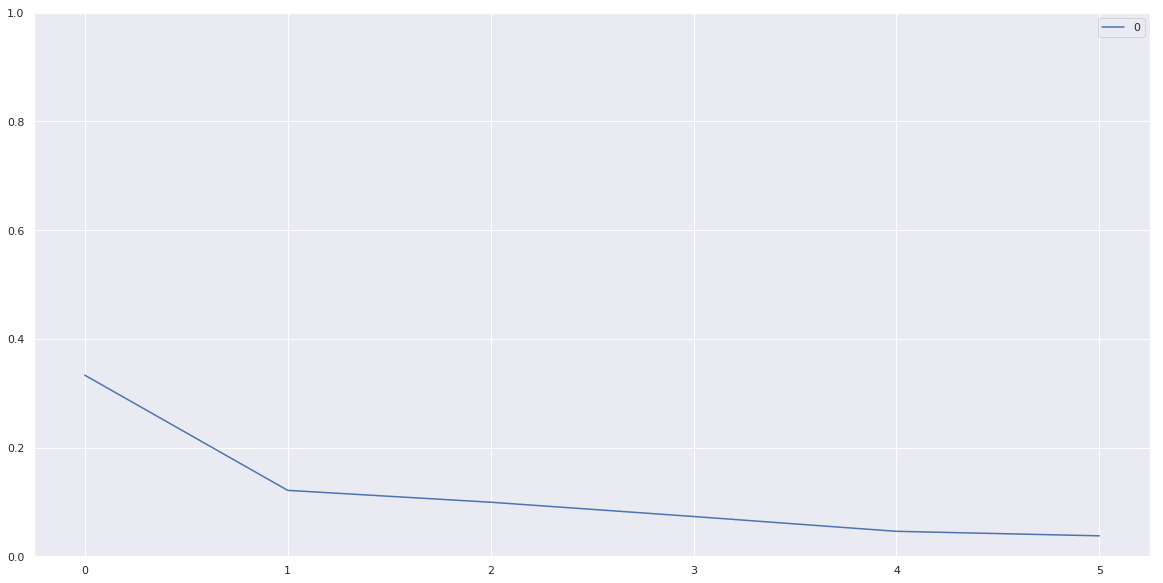

In [35]:
pd.DataFrame(fullscene_pca_model.explained_variance_ratio_).plot(ylim=[0,1])
print("Cumulative explained variance: %s" % fullscene_pca_model.explained_variance_ratio_.cumsum())

### Plotting of the embeding

`plot_embedding` plots each questionnaire's response when projected along the first 2 eigenvectors. Responses' colours correspond to the clips.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

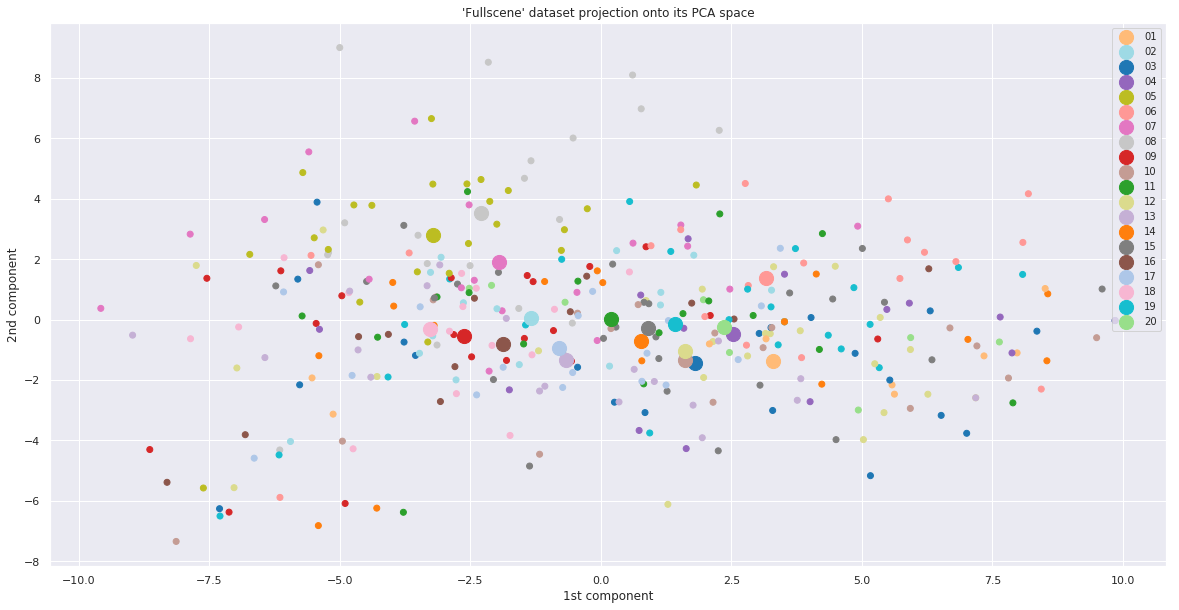

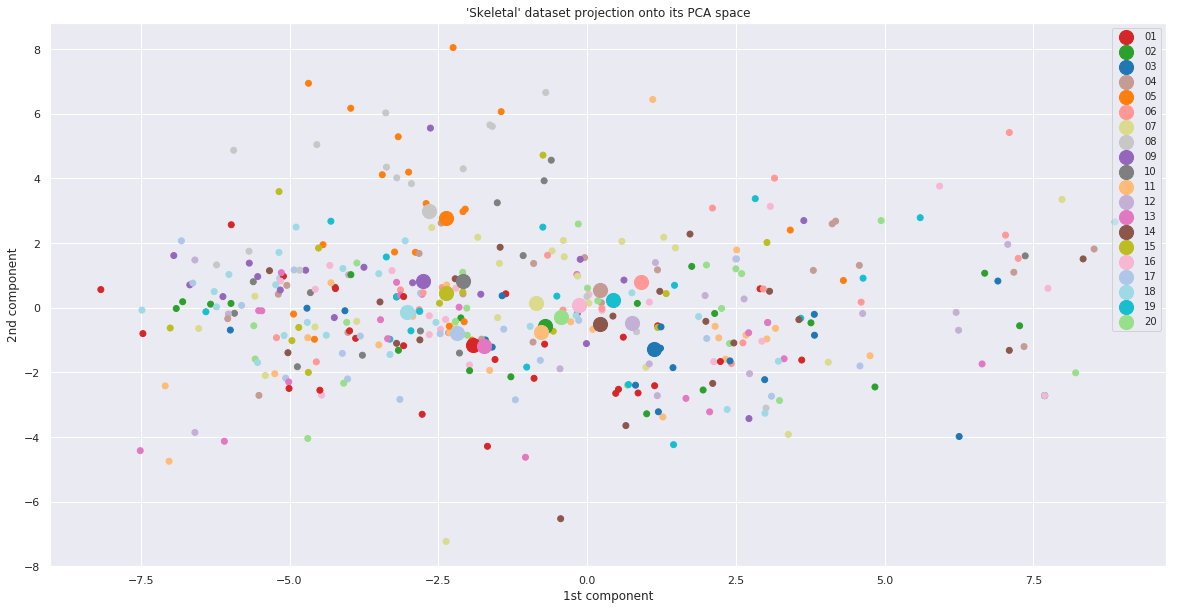

In [36]:
plot_embedding(fullscene_pca, fullscene_labels, fullscene_means_pca, fullscene_means.index, title="'Fullscene' dataset projection onto its PCA space", three_d=False)
plot_embedding(skel_pca, skel_labels, skel_means_pca, skel_means.index, title="'Skeletal' dataset projection onto its PCA space", three_d=False) 

For each clip, we can then plot the distance between its embedding based on fullscene ratings vs its embedding based on skeletal data only.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

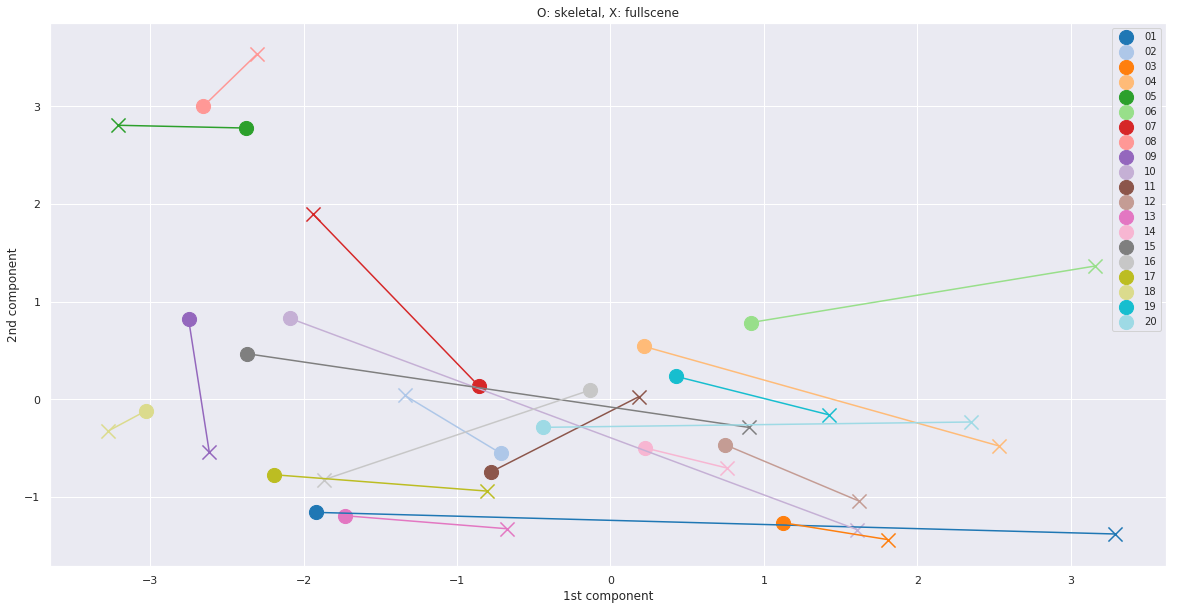

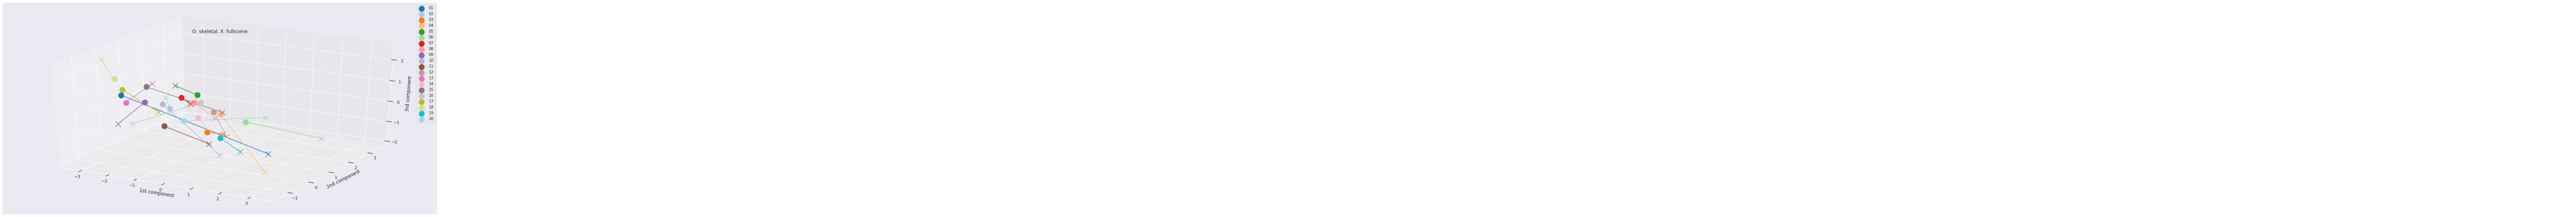

In [37]:
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index, title="O: skeletal, X: fullscene", three_d=False)
plot_compare_embeddings(skel_means_pca, fullscene_means_pca, skel_means.index, title="O: skeletal, X: fullscene", three_d=True)

Computing the actual distance between clips in the two conditions shows that they are generally quite far apart. A straightforward PCA embedding does not seem to be effective to evidence similarities between our 2 conditions.

In [38]:
distances_pca=pd.DataFrame(np.power(np.sum(np.power(skel_means_pca - fullscene_means_pca, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_pca"])
show_heatmap(distances_pca, cmap="summer_r")

,distance_pca
clipId,
01,5.8938
02,0.904112
03,1.73459
04,4.33966
05,1.2738
06,2.41302
07,2.67892
08,1.57773
09,1.52314


To answer the question: *does a PCA evidence common latent factors between our 2 conditions?*, we compute a PCA model *based on the skeletal data*, and compare the resulting PCA components with the ones found with the fullscene data.

We observe that the resulting loadings look very different.

In [39]:
# plot of PCA components, with fullscene vs skeleton components side-by-side


skel_pca_model=PCA(n_components=nb_components).fit(skel)

skel_pca = skel_pca_model.transform(skel)
skel_means_pca = skel_pca_model.transform(skel_means.values)



skel_pca_components = pd.DataFrame(skel_pca_model.components_,columns=columnsDiffSum).T
fullscene_pca_components = pd.DataFrame(fullscene_pca_model.components_,columns=columnsDiffSum).T

# merge PCA components into one dataframe, skel and fullscene side-by-side
pca_components=pd.concat([skel_pca_components, fullscene_pca_components], keys=["skel", "fullscene"], axis=1)
pca_components=pca_components.swaplevel(0,1,1).sort_index(1)


show_heatmap(pca_components[abs(pca_components)>0.2], m=-0.6, M=0.6)


/home/skadge/.local/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


## LDA

We perform the LDA *on top of the PCA* as LDA typically requires O > 3 F, with O the nb of observations and F the nb of features (here, we have ~26 observations for originally 22 questions). Using the PCA as a dimensionality reduction tool, we bring down the number of degrees of freedom to 6.

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_nb_components = 4

fullscene_lda_model = LinearDiscriminantAnalysis(n_components=lda_nb_components, solver='svd')
fullscene_lda_model.fit(fullscene_pca, fullscene_labels)

fullscene_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(fullscene))
fullscene_means_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(fullscene_means.values))

skel_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(skel))
skel_means_lda = fullscene_lda_model.transform(fullscene_pca_model.transform(skel_means.values))


Attention: the variance explained by the LDA transformation is the variance in the *PCA* space, not in the original 22-D space of the questionnaire!

In [41]:
print("Cumulative explained variance by LDA: %s" % fullscene_lda_model.explained_variance_ratio_.cumsum())

Cumulative explained variance by LDA: [0.44355966 0.70321882 0.849057   0.91358403]


When projected in the PDA space, the clips in condition *skeleton* vs *fullscene* are much closer to one another.

In [42]:
distances_lda=pd.DataFrame(np.power(np.sum(np.power(skel_means_lda - fullscene_means_lda, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_lda"])

distances = pd.concat([distances_pca, distances_lda], axis=1)
show_heatmap(distances, cmap="summer_r")


,distance_pca,distance_lda
clipId,,
01,5.8938,1.96528
02,0.904112,0.370138
03,1.73459,1.04416
04,4.33966,2.45472
05,1.2738,0.48901
06,2.41302,0.683214
07,2.67892,1.29882
08,1.57773,0.703964
09,1.52314,0.619488


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

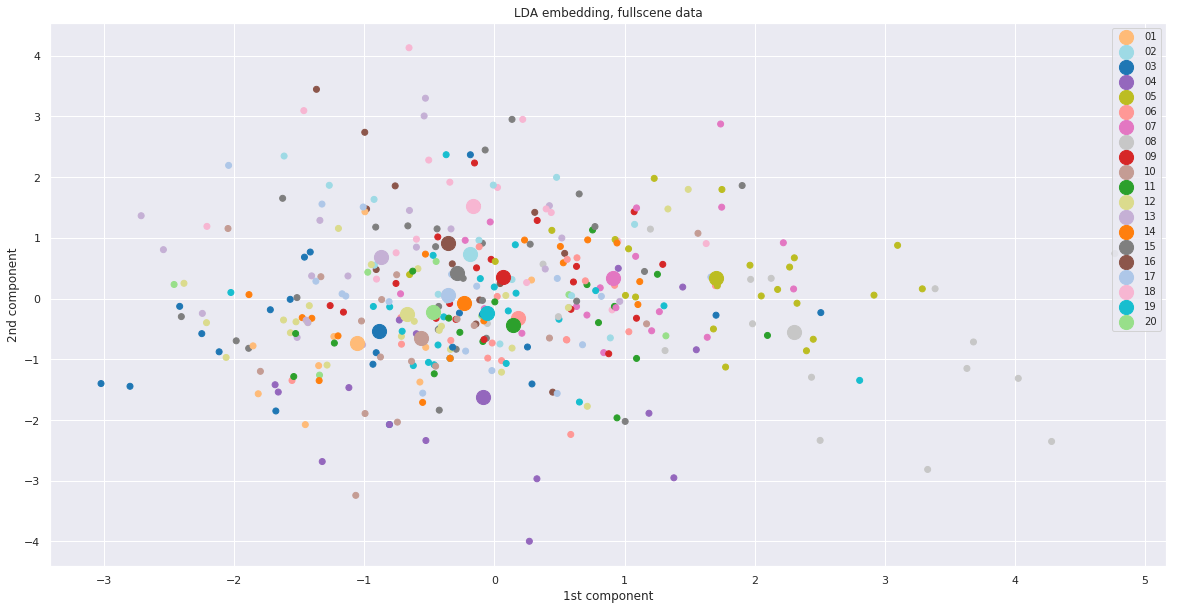

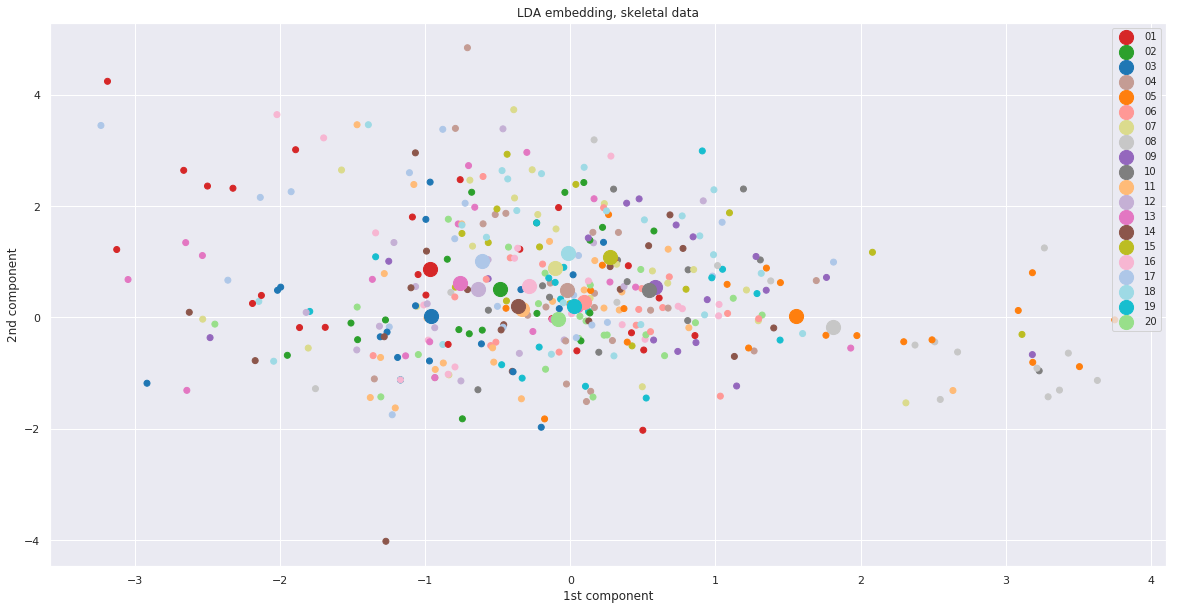

In [43]:
plot_embedding(fullscene_lda, fullscene_labels,fullscene_means_lda, fullscene_means.index, title="LDA embedding, fullscene data", three_d=False)
plot_embedding(skel_lda, skel_labels,skel_means_lda, skel_means.index, title="LDA embedding, skeletal data", three_d=False)

In [ ]:
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, fullscene_means.index,three_d=False)
plot_compare_embeddings(skel_means_lda, fullscene_means_lda, skel_means.index,three_d=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

To answer the question: *does a PCA evidence common latent factors between our 2 conditions?*, we can again create a new LDA model for the skeletal data, and print out the LDA components for *fullscene* vs *skeleton* side-by-side.

We observe that they still look very different.

In [ ]:
# compute as well a LDA model from the skeletal PCA to compare components with fullscene
skel_lda_model = LinearDiscriminantAnalysis(n_components=lda_nb_components, solver='svd')
skel_lda_model.fit(skel_pca, skel_labels)


fullscene_lda_components = pd.DataFrame(fullscene_lda_model.scalings_[:,:lda_nb_components].T).T
skel_lda_components = pd.DataFrame(skel_lda_model.scalings_[:,:lda_nb_components].T).T

# merge PCA components into one dataframe, skel and fullscene side-by-side
lda_components=pd.concat([fullscene_lda_components, skel_lda_components], keys=["fullscene", "skel"], axis=1)
lda_components=lda_components.swaplevel(0,1,1).sort_index(1)

show_heatmap(lda_components[abs(lda_components)>0.2], m=-0.6, M=0.6)

By multiplying the LDA loadings matrix with the PCA loadings matrix, we can compute the LDA loadings in terms of the original questions asked to the participants.

In [ ]:
lda_fullscene_loadings=pd.DataFrame(np.dot(fullscene_pca_components, fullscene_lda_components), index=pca_components.index, columns=["LDA component %d" % (i+1) for i in range(lda_nb_components)])
lda_skel_loadings=pd.DataFrame(np.dot(skel_pca_components, skel_lda_components), index=pca_components.index, columns=["LDA component %d" % (i+1) for i in range(lda_nb_components)])
# merge loadings into one dataframe, skel and fullscene side-by-side
lda_loadings=pd.concat([lda_fullscene_loadings, lda_skel_loadings], keys=["fullscene","skel"], axis=1)
lda_loadings=lda_loadings.swaplevel(0,1,1).sort_index(1)

from scipy.stats import pearsonr

print("Pearson correlation between LDA components 'fullscene' vs 'skeletal'")
for i in range(1, lda_nb_components + 1):
    r, p=pearsonr(lda_loadings["LDA component %d" % i]["fullscene"].values, lda_loadings["LDA component %d" % i]["skel"].values)
    print("LDA component %d: r=%f, p=%f" % (i,r,p)) 


show_heatmap(lda_loadings, m=-0.6, M=0.6)

## Explorative Factor Analysis

The Python [factor_analyzer](https://factor-analyzer.readthedocs.io) module is a port of EFA from the R' `psych` package.

In [ ]:
import factor_analyzer

rotation = 'promax'

nb_factors=3

fa_skel = factor_analyzer.FactorAnalyzer()
fa_skel.analyze(skel_ratings_df, nb_factors, rotation=rotation)
skel_loadings=fa_skel.loadings

fa_fullscene = factor_analyzer.FactorAnalyzer()
fa_fullscene.analyze(fullscene_ratings_df, nb_factors, rotation=rotation)
fullscene_loadings=fa_fullscene.loadings

Comparing the loadings for the *fullscene* vs the *skeletal* only data show that the first two factors are highly correlated. **This shows that, using factor analysis, we have uncovered latent constructs that are used by participants to describe the clips in both *fullscene* and *skeletal-only* conditions**.

In [ ]:
# merge loadings into one dataframe, skel and fullscene side-by-side
loadings=pd.concat([fullscene_loadings, skel_loadings], keys=["fullscene","skel"], axis=1)
loadings=loadings.swaplevel(0,1,1).sort_index(1)

from scipy.stats import pearsonr

print("Pearson correlation between factors 'fullscene' vs 'skeletal'")
for i in range(1, nb_factors+1):
    r, p=pearsonr(loadings["Factor%d" % i]["fullscene"].values, loadings["Factor%d" % i]["skel"].values)
    print("Factor %d: r=%f, p=%f" % (i,r,p)) 
    
    
show_heatmap(loadings[abs(loadings)>=0.3])


constructs=["Dominant", "Cooperative", "Competitive", "Friendly", "Aggressive", "Engaged", "Fearful", "Sad", "Content", "Angry", "Amused"]

loadings2 = pd.DataFrame()

for c in constructs:
    loadings2[c + ": diff."] = abs(loadings.T["left" + c] - loadings.T["right" + c])
    loadings2[c + ": mag."] = np.amax([abs(loadings.T["left" + c]), abs(loadings.T["right" + c])], axis=0)

show_heatmap(loadings2.T, cmap="summer_r")


In [ ]:
fa_skel.get_factor_variance()


In [ ]:
fa_fullscene.get_factor_variance()

### EFA embeddings

We can use the EFA space as a 'better' space to represent our clips, where the latent, composite constructs correspond to the main axis:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


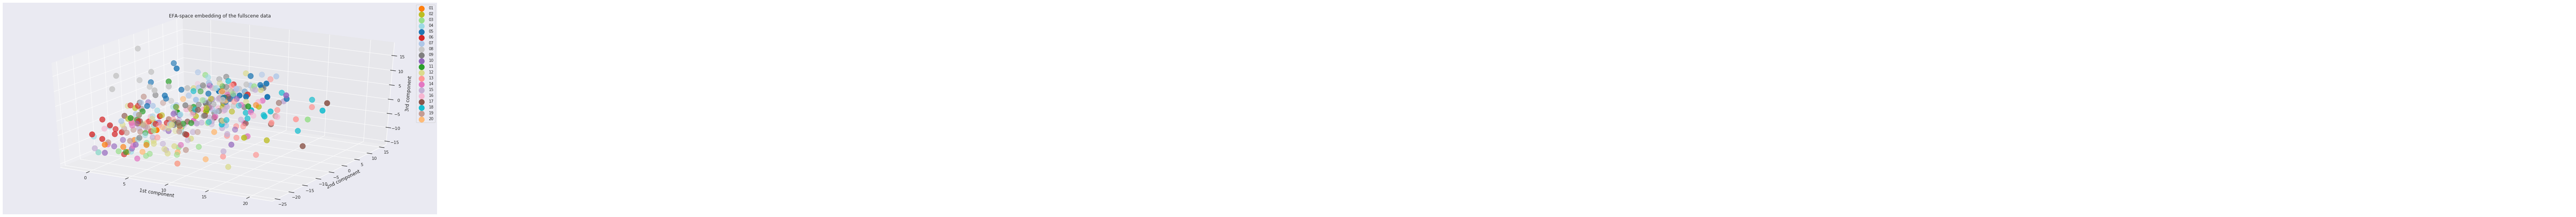

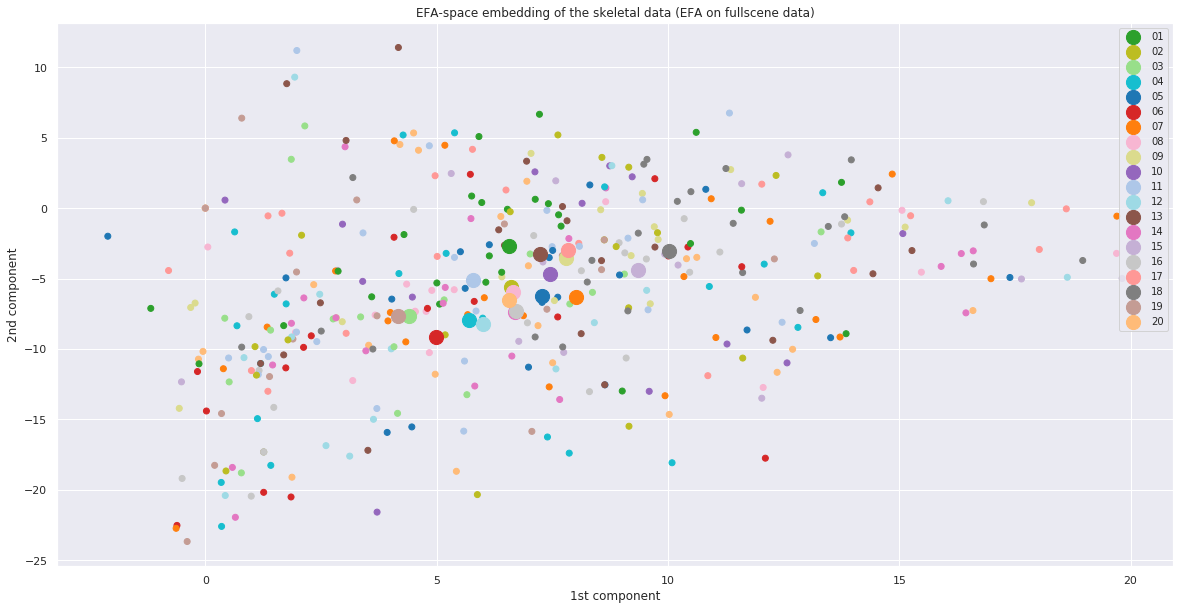

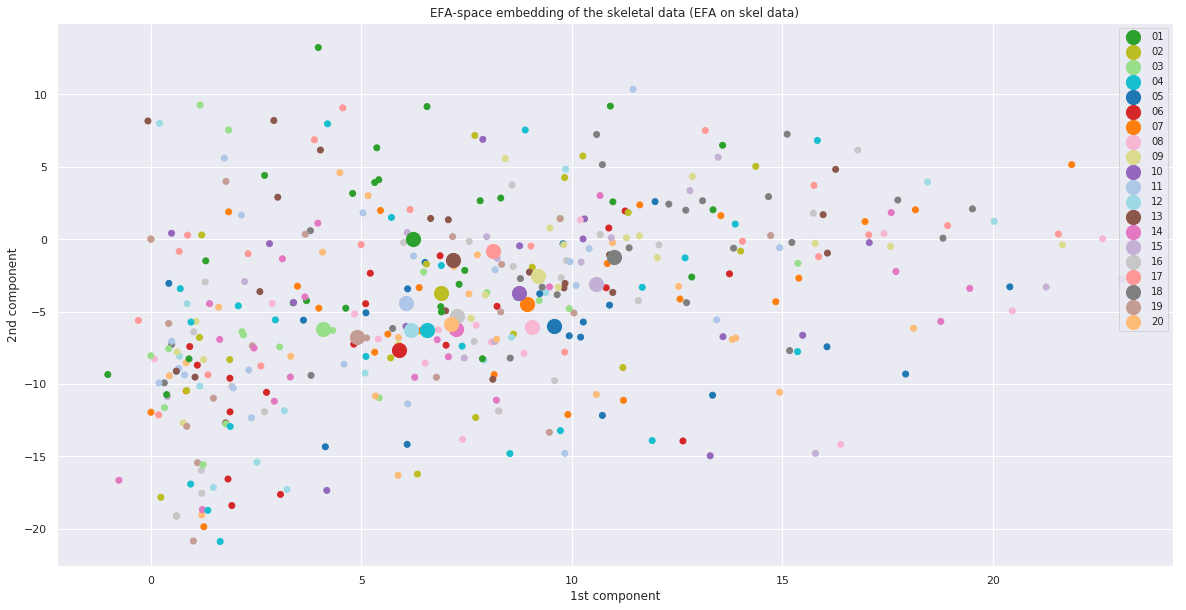

In [47]:
nb_of_factors=6
fullscene_efa = np.dot(fullscene,fullscene_loadings.values[:,:nb_of_factors])
fullscene_means_efa = np.dot(fullscene_means,fullscene_loadings.values[:,:nb_of_factors])
skel_efa = np.dot(skel,fullscene_loadings.values[:,:nb_of_factors])
skel_means_efa = np.dot(skel_means,fullscene_loadings.values[:,:nb_of_factors])

skel_pure_efa = np.dot(skel,skel_loadings.values[:,:nb_of_factors])
skel_pure_means_efa = np.dot(skel_means,skel_loadings.values[:,:nb_of_factors])


plot_embedding(fullscene_efa, fullscene_labels,fullscene_means_efa, fullscene_means.index, title="EFA-space embedding of the fullscene data", three_d=True)
plot_embedding(skel_efa, skel_labels,skel_means_efa, skel_means.index, title="EFA-space embedding of the skeletal data (EFA on fullscene data)", three_d=False)
plot_embedding(skel_pure_efa, skel_labels,skel_pure_means_efa, skel_means.index, title="EFA-space embedding of the skeletal data (EFA on skel data)", three_d=False)


Interestingly, even if the EFA factors are quite similar, the distances between same clips in fullscene vs skeletal data are higher in the EFA space compared to the PCA or LDA space:

In [ ]:
distances_efa=pd.DataFrame(np.power(np.sum(np.power(skel_means_efa - fullscene_means_efa, 2), axis=1), 0.5), index=skel_means.index, columns=["distance_efa"])

distances = pd.concat([distances_pca, distances_lda, distances_efa], axis=1)
print("Mean distances:\n%s" % distances.mean(axis=0))
show_heatmap(distances, cmap="summer_r")


# Clustering



Based on the distance measurements, the LDA space seems to be the best to cluster our clips.
We can then attempt to cluster our 20 clips into 'groups' of similar clips (based on the latent constructs):

In [ ]:
from sklearn.cluster import KMeans

# kMeans clustering after projecting our clips in the EFA-space
fullscene_clustering_data=fullscene_means_efa

nb_clusters=5

fullscene_kmeans_model = KMeans(n_clusters=nb_clusters, random_state=0).fit(fullscene_clustering_data)
fullscene_kmeans = fullscene_kmeans_model.predict(fullscene_clustering_data)

plot_embedding(fullscene_clustering_data,fullscene_means.index,clusters=fullscene_kmeans, three_d=True)

pd.DataFrame(fullscene_kmeans, index=fullscene_means.index, columns=["cluster #"]).sort_values(by="cluster #")

We should be able to infer the semantics of the 3 first EFA factors.


We can then try to predict in which cluster the clips would end up, using only the ratings from the skeletal videos:

In [ ]:
skel_means_efa.shape

In [ ]:
skel_kmeans= fullscene_kmeans_model.predict(skel_means_efa)

plot_embedding(fullscene_means_efa,skel_means.index, clusters=skel_kmeans, three_d=False)

diff=pd.DataFrame(fullscene_kmeans-skel_kmeans,index=skel_means.index)
print("%d skeleton clips out of %d (%.1f%%) are predicted to fall into the same cluster as their 'fullscene' counterpart." % (diff[diff==0].count(), skel_kmeans.size, diff[diff==0].count() * 100. / skel_kmeans.size))

clusters_kripp=pd.DataFrame([fullscene_kmeans, skel_kmeans, fullscene_kmeans==skel_kmeans,krippendorff_df[["alpha(fullscene)", "alpha(skel)"]].std(axis=1).astype(float), krippendorff_df[["alpha(fullscene)", "alpha(skel)"]].mean(axis=1).astype(float), krippendorff_df["alpha(fullscene)"], krippendorff_df["alpha(skel)"], ],index=["fullscene clusters", "skel clusters", "same", "kripp alpha std", "kripp alpha mean", "alpha(fullscene)", "alpha(skel)"],columns=skel_means.index).T.sort_values(by="kripp alpha mean")
clusters_kripp

# Classification

Using a SVM classifier, we can try to improve our predictions:

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')

# trying with skel, skel_pca, skel_lda do not lead to any clear improvements
training_set = fullscene_means_efa
training_labels = fullscene_kmeans

testing_set = skel_means_efa
# Critically, we are testing with the *fullscene_kmeans* as we want to check whether 
# we predict the same clusters as with the fullscene stimuli.
testing_labels = fullscene_kmeans

clf.fit(training_set, training_labels)

In [ ]:
for p, l in zip(clf.predict(testing_set), testing_labels):
    print("%s (should be %s)" % (p,l))
print("SVM: %.1f%% successful prediction out of %d tested clips" % (clf.score(testing_set, testing_labels) * 100, len(testing_labels)))

In [ ]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(testing_labels, clf.predict(testing_set))
plot_confusion_matrix(cnf_matrix, classes=pd.unique(testing_labels))